<a href="https://colab.research.google.com/github/jonathan18wjn/jonathan18wjn/blob/main/GIS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 7 A Spatial Analysis on Chicago Crime

Jianing Wang

### 1. Introduction

According to the data released by Chicago Police Department, there have been 524 murders in Chicago in 2021, which is significantly high compared to other cities in the United States. On November 9th, a University of Chicago graduate student Shaoxiong Zheng was killed during a
robbery in Hyde Park. Crime has been one of the most serious issues in the city of Chicago. Therefore, it is important to learn the distribution of crimes and to examine the plausible reasonings behind this worrying situation.
There are two main research questions for this project:
1. What are the spatial patterns of violent crime in Chicago?
2. What are the geographical and social factors that might cause potential clusters of crime incidents in Chicago?

The boundary data used are downloaded from open data Chicago. The crime data are gathered from the Chicago Police Department website that includes the one-year crime data from December 2020 to December 2021. However, for this very specific study, we are more interested in the violent crimes in Chicago.

### 2. Exploratory Analysis on the crime data

In [40]:
import pandas as pd
crime = pd.read_csv("Crimes-Map.csv")
crime.head()

crime.columns

Index(['CASE#', 'DATE  OF OCCURRENCE', 'BLOCK', ' IUCR',
       ' PRIMARY DESCRIPTION', ' SECONDARY DESCRIPTION',
       ' LOCATION DESCRIPTION', 'ARREST', 'DOMESTIC', 'BEAT', 'WARD', 'FBI CD',
       'X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')

In [ ]:
# Data filtering
'''
violent = crime[(crime[" PRIMARY DESCRIPTION"] == "ASSAULT") | 
                (crime[" PRIMARY DESCRIPTION"] == "BATTERY") |
                (crime[" PRIMARY DESCRIPTION"] == "CRIMINAL SEXUAL ASSAULT") |
                (crime[" PRIMARY DESCRIPTION"] == "HOMICIDE") |
                (crime[" PRIMARY DESCRIPTION"] == "HUMAN TRAFFICKING") |
                (crime[" PRIMARY DESCRIPTION"] == "INTIMIDATION") |
                (crime[" PRIMARY DESCRIPTION"] == "KIDNAPPING")]

violent.head()
'''

In [41]:
violent = pd.read_csv("violent final.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
"""
crime_count = pd.DataFrame(violent[' PRIMARY DESCRIPTION'].value_counts())
crime_count.sort_values(' PRIMARY DESCRIPTION',ascending=False)
crime_count
"""

<Figure size 720x720 with 0 Axes>

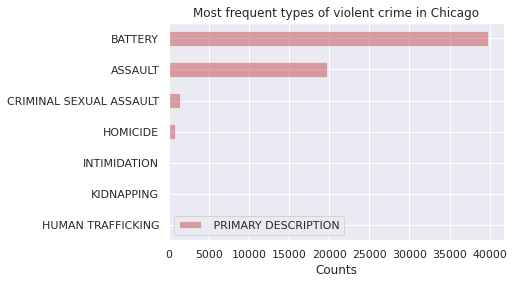

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set()
crime_count.plot.barh(color = 'r', alpha = 0.5)
plt.gca().invert_yaxis()
plt.title("Most frequent types of violent crime in Chicago")
plt.xlabel("Counts")

plt.savefig("violent_count.png",bbox_inches = 'tight')

plt.show()

The frequencies of violent crimes are shown in the graph above. We can see that Battery is the most frequent violent crimes in Chicago city at 39,751 times, followed by Assault at 19,711. Although the other types of violent crimes, such as homicide and intimidation, are significantly lower in frequency than battery and assault, they are also comparatively higher in frequency compared to other major cities in the United States.

### 3. Violent Crime Mapping

In [42]:
from shapely.geometry import Point
import pandas as pd
import json
import requests

points=[]

# iterate through the stations and for each station, create a Point using the station's latitude and longitude
for station in crime.index:
    p=Point(crime.loc[station,'LONGITUDE'], crime.loc[station, 'LATITUDE'])
    points.append(p)
    
# create a new column in citibike that contains the list of Points
crime['points']=points

In [ ]:
!pip install geopandas

In [44]:
import geopandas

nta1 = geopandas.read_file("violent crime final.shp")

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [46]:
nta1.sample(5)

,POLY_ID,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,violent_co,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,...,eEAT_F11G,eEAT_F12N,eEAT_FHSC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,count_viol,LISA_I,LISA_CL,LISA_P,geometry
346,347.0,28,28.0,031,17031833000,8330,Census Tract 8330,None,17,833000,112.0,18879,17,031,17031,243600,17031243600,330,2357.1,598,4242.9,276,30,0,11,0,7,6,15,197,133,12,7,6,80,111,62,40,12,34.7,...,0,0,0,0,16,0,62,27,0,0,347,206,141,267,164,101,250,158,92,16,16,17,17,18,18,18,18,18,18,19,19,19,19,250,11,112.0,-0.108842,4.0,0.011,"POLYGON ((-87.65203 41.88170, -87.65226 41.881..."
4163,4164.0,28,28.0,031,17031280100,2801,Census Tract 2801,None,17,280100,59.0,18879,17,031,17031,243600,17031243600,330,2357.1,598,4242.9,276,30,0,11,0,7,6,15,197,133,12,7,6,80,111,62,40,12,34.7,...,0,0,0,0,16,0,62,27,0,0,347,206,141,267,164,101,250,158,92,16,16,17,17,18,18,18,18,18,18,19,19,19,19,250,11,59.0,-0.215978,3.0,0.001,"POLYGON ((-87.64572 41.88180, -87.64592 41.881..."
3606,3607.0,75,75.0,031,17031750600,7506,Census Tract 7506,None,17,750600,129.0,19422,17,031,17031,750600,17031750600,4486,8796.1,4214,8323.5,33,4389,2,11,0,20,31,63,2053,2433,279,900,275,394,570,608,714,746,37.7,...,31,80,271,177,274,94,224,110,0,4,3846,1765,2081,1733,830,896,1537,763,774,105,105,106,106,106,106,109,111,112,112,114,115,115,115,1537,52,129.0,0.438848,1.0,0.001,"POLYGON ((-87.66120 41.68929, -87.66141 41.689..."
2840,2841.0,46,46.0,031,17031461000,4610,Census Tract 4610,None,17,461000,78.0,19205,17,031,17031,520200,17031520200,4289,8935.4,4285,8952.1,1739,104,60,2,1,2224,159,3608,2154,2135,482,1088,303,568,632,512,387,317,25.7,...,35,48,366,45,141,53,21,7,0,0,5185,2613,2572,1939,1002,932,1296,785,511,90,90,91,92,92,92,92,92,93,93,93,94,94,98,1296,55,78.0,0.000480,0.0,0.497,"POLYGON ((-87.55463 41.73004, -87.55430 41.730..."
1084,1085.0,56,56.0,031,17031835200,8352,Census Tract 8352,None,17,835200,46.0,19223,17,031,17031,560500,17031560500,673,5608.3,679,5666.7,514,5,2,14,0,96,42,171,325,348,47,133,37,78,116,87,93,82,33.5,...,12,8,84,0,24,20,22,0,0,0,627,308,319,309,126,182,289,113,176,20,20,20,20,20,20,21,21,21,21,21,21,21,22,289,8,46.0,0.316501,2.0,0.001,"POLYGON ((-87.75274 41.80019, -87.75249 41.800..."


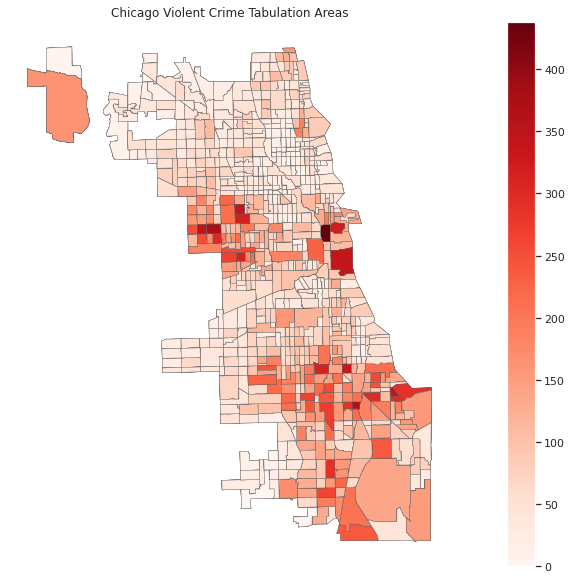

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10)) #Put this figure on an axis. Make this 20 wide by 10 tall
plt.title("Chicago Violent Crime Tabulation Areas")
plt.axis('off') # This removes the border & axes labels. 
nta1.plot(column="count_viol", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")

bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=438))
bar_info._A = []
cbar = fig.colorbar(bar_info)

plt.savefig("violent heatmap.png",bbox_inches = 'tight')

We can also examine the spatial dependency of violent crimes in the city of Chicago. In order to do that we can calculate the Moran’s I to see if there is spatial autocorrelation. The spatial weight applied in this research is the Queen’s contiguity, where neighbors are defined as the two
polygons that share the common boundary or vertex. The Moran’s I scatterplot is shown on the graph above on the left. The Moran’s I scatterplot shows that the Moran’s I value for violent crime is 0.55, which shows the evidence of positive spatial autocorrelation, where high or low values of violent crimes forms clusters in the space.

To show the areas where clusters are formed, we can create a Local Indicators of Spatial Association (LISA) cluster map. The results are shown on the upper right side. From the graph, we can see that, generally, northern Chicago is comparatively safer than the southern part of Chicago in terms of the frequency of violent crimes. We can see that there are Low-Low clusters forming around north Chicago and lower western Chicago, while High-High clusters are formed around southern Chicago and midtown Chicago.

Weighted Mean and sd ecllipse

In [ ]:
!apt install python3-rtree
!pip install pysal

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import weighted_ellipse
import requests
import zipfile

from matplotlib.patches import Ellipse
from pylab import figure

import matplotlib.transforms as transforms

from pointpats import PointPattern
from pointpats.centrography import mean_center, weighted_mean_center, ellipse, std_distance

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [47]:
coords = [[p.x, p.y] for p in nta1.centroid] #create a list of coordinate pairs

pp = PointPattern(coords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [48]:
pp.points 

,x,y
0,-87.630040,41.742475
1,-87.630040,41.742475
2,-87.630040,41.742475
3,-87.630040,41.742475
4,-87.630040,41.742475
...,...,...
4271,-87.715707,41.856652
4272,-87.708365,41.789811
4273,-87.708365,41.789811
4274,-87.708365,41.789811


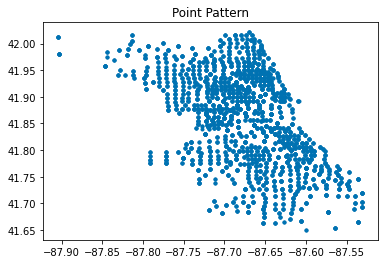

In [49]:
pp.plot();

<Figure size 1440x720 with 0 Axes>

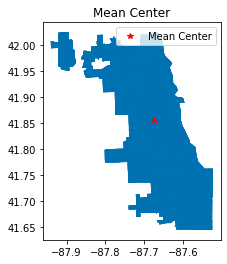

In [50]:
plt.figure(figsize=(20,10))
center = mean_center(pp.points)

nta1.plot()
plt.plot(center[0], center[1], 'r*', label='Mean Center')
plt.title("Mean Center")
plt.legend(numpoints=1);

In [5]:
violent = pd.read_csv("violent final.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
!apt install python3-rtree
!pip install pysal #Python Spatial Analysis Library
!pip install mapclassify
!pip install geopandas
!pip install splot

In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import pysal
import mapclassify
import requests
from zipfile import ZipFile

In [ ]:
chi = gpd.read_file("lisa.shp")
chi.head()

In [10]:
import libpysal
w = libpysal.weights.Queen.from_dataframe(chi)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [17]:
from esda.moran import (Moran, Moran_Local)

mi = Moran(chi['count_viol'], w)

In [18]:
from splot.esda import (moran_scatterplot, lisa_cluster, plot_local_autocorrelation)

Text(0.5, 0, 'spatial lag')

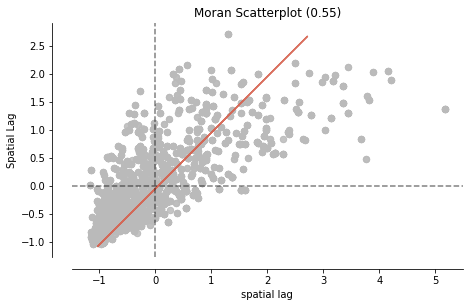

In [22]:
moran_scatterplot(mi)
plt.xlabel("spatial lag")

In [20]:
lisa = Moran_Local(chi['count_viol'], w)

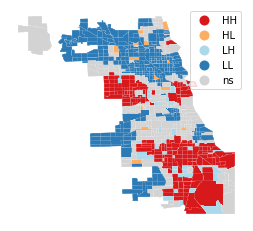

In [21]:
lisa_cluster(lisa, chi, p=.01);

We can also examine the spatial dependency of violent crimes in the city of Chicago. In order to do that we can calculate the Moran’s I to see if there is spatial autocorrelation. The spatial weight applied in this research is the Queen’s contiguity, where neighbors are defined as the two
polygons that share the common boundary or vertex. The Moran’s I scatterplot is shown on the graph above on the left. The Moran’s I scatterplot shows that the Moran’s I value for violent crime is 0.55, which shows the evidence of positive spatial autocorrelation, where high or low values of violent crimes forms clusters in the space.

To show the areas where clusters are formed, we can create a Local Indicators of Spatial Association (LISA) cluster map. The results are shown on the upper right side. From the graph, we can see that, generally, northern Chicago is comparatively safer than the southern part of Chicago in terms of the frequency of violent crimes. We can see that there are Low-Low clusters forming around north Chicago and lower western Chicago, while High-High clusters are formed around southern Chicago and midtown Chicago.

### 5. Spatial Regression Model

OLS

In [52]:
!pip install mapclassify
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 1s (58.1 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155311 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

In [53]:
import pysal
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
import mapclassify
import geoplot as gplt
import geoplot.crs as gcrs

In [25]:
violent.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,violent_co,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,MED_AGE_M,...,eEAT_MDOC,eEAT_F25P,eEAT_F9G,eEAT_F10G,eEAT_F11G,eEAT_F12N,eEAT_FHSC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,count_violent
0,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19156,17,31,17031,440300,17031440300,5165,10330.0,4888,9836.0,25,5060,8,3,8,10,51,26,2264,2901,281,737,171,442,638,767,880,1249,43.9,41.9,...,6,1695,7,36,27,83,375,151,306,116,263,229,45,12,4138,1812,2326,2064,942,1117,1749,743,1006,120,121,121,121,123,124,124,125,127,127,127,127,130,132,1749,52,273
1,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19157,17,31,17031,440400,17031440400,3833,6182.3,3588,5827.4,23,3777,1,8,0,3,21,16,1741,2092,251,640,174,395,480,524,645,724,39.5,36.9,...,6,1269,29,29,29,128,314,89,267,84,160,84,0,0,3218,1459,1759,1408,664,738,1134,476,658,77,77,79,79,79,80,80,83,83,83,83,83,84,84,1134,32,273
2,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19158,17,31,17031,440500,17031440500,11,84.6,11,84.6,1,9,0,0,0,0,1,0,5,6,1,2,1,0,1,4,1,1,42.2,42.8,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,273
3,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19159,17,31,17031,440600,17031440600,2404,9246.2,2303,8919.2,12,2356,1,4,5,8,18,16,1090,1314,155,424,108,177,330,414,351,445,40.2,38.1,...,0,935,25,5,26,30,172,50,225,33,243,85,16,0,2356,1063,1293,1157,495,660,1042,396,646,72,72,72,72,74,74,75,75,76,76,76,76,76,76,1042,27,273
4,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19182,17,31,17031,490100,17031490100,596,4584.6,555,4292.3,3,581,1,1,0,7,3,12,269,327,42,148,33,39,85,80,85,84,35.0,30.8,...,0,208,12,8,11,9,67,11,57,16,12,0,0,0,517,229,288,201,72,127,110,43,67,7,7,7,8,8,8,8,8,8,8,8,8,8,9,110,3,273


In [54]:
data_reg = violent[["POP2009", "MED_AGE","eSHAVGINC",
                    "eSPERCPINC", "eFMMEDINC", "eTotExpend",
                    "eTVhclPrch", "eTCarTrkN", "eReading",
                    "eTobacco",	"eEAT_MCG1", "eEAT_MCG1P",
                    "eEAT_MASD",	"eEAT_MBAC", "eEAT_FCG1",
                    "eEAT_FCG1P", "eEAT_FASD",	"eEAT_FBAC",
                    "eEMPLOYED","count_violent"]]	

data_reg.head()	

,POP2009,MED_AGE,eSHAVGINC,eSPERCPINC,eFMMEDINC,eTotExpend,eTVhclPrch,eTCarTrkN,eReading,eTobacco,eEAT_MCG1,eEAT_MCG1P,eEAT_MASD,eEAT_MBAC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEMPLOYED,count_violent
0,4888,43.9,51677.0,22704,55133.6,76908085.5,3611.4,2087.3,109.1,279.3,136,280,112,164,151,306,116,263,1749,273
1,3588,39.5,46093.0,16658,44882.5,46043175.0,3393.3,1892.1,103.1,274.5,34,208,23,120,89,267,84,160,1134,273
2,11,42.2,721224.0,480816,0.0,158190.4,6738.7,4796.8,195.1,317.4,0,0,0,0,0,0,0,0,1,273
3,2303,40.2,62584.0,22978,55535.8,42707116.1,4265.6,2594.3,125.8,290.0,17,136,74,90,50,225,33,243,1042,273
4,555,35.0,43409.0,14525,40946.0,6772868.0,3365.3,1862.9,100.9,270.5,5,11,5,0,11,57,16,12,110,273


In [55]:
target='count_violent'
features=["POP2009", "MED_AGE","eSHAVGINC",
                    "eSPERCPINC", "eFMMEDINC", "eTotExpend",
                    "eTVhclPrch", "eTCarTrkN", "eReading",
                    "eTobacco",	"eEAT_MCG1", "eEAT_MCG1P",
                    "eEAT_MASD",	"eEAT_MBAC", "eEAT_FCG1",
                    "eEAT_FCG1P", "eEAT_FASD",	"eEAT_FBAC",
                    "eEMPLOYED"]

Y = data_reg[target].values.reshape(len(data_reg),1) #add dimension for spreg OLS DV
X = data_reg[features].values

In [56]:
Y.shape,data_reg[target].shape

((4276, 1), (4276,))

In [57]:
import spreg

ols=spreg.OLS(Y, X, w=w, \
                          name_y="violence", name_x=["POP2009", "MED_AGE","eSHAVGINC",
                    "eSPERCPINC", "eFMMEDINC", "eTotExpend",
                    "eTVhclPrch", "eTCarTrkN", "eReading",
                    "eTobacco",	"eEAT_MCG1", "eEAT_MCG1P",
                    "eEAT_MASD",	"eEAT_MBAC", "eEAT_FCG1",
                    "eEAT_FCG1P", "eEAT_FASD",	"eEAT_FBAC",
                    "eEMPLOYED"], name_w="queen's continuity",\
                          nonspat_diag=True, #print stats
                          spat_diag=True,  #print Lagrange multiplier tests 
                          moran=True)  # compute Moran’s I on the residuals
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :queen's continuity
Dependent Variable  :    violence                Number of Observations:        4276
Mean dependent var  :     80.9790                Number of Variables   :          20
S.D. dependent var  :     69.0611                Degrees of Freedom    :        4256
R-squared           :      0.2455
Adjusted R-squared  :      0.2422
Sum squared residual:15383198.630                F-statistic           :     72.8961
Sigma-square        :    3614.473                Prob(F-statistic)     :  4.635e-243
S.E. of regression  :      60.120                Log likelihood        :  -23573.353
Sigma-square ML     :    3597.568                Akaike info criterion :   47186.707
S.E of regression ML:     59.9797                Schwarz criterion     :   47313.922

-----------------------------------------------------------------------

The table on the left shows the result of the ordinary least squared regression output. From the summary we can see that, variables like POP2009 (total population), eSPERCPTINC (Per Capita Income), eEAT_MCG1 (Male 25+ Some college, under 1 year), eEAT_MCG1P (Male 25+ Some college, 1+ years, no degree), eEAT_FCG1P (Female 25+ Some college, 1+ years, no degree), eEMPLOYED (Employed) are the variables that are statistically significant.

The table on the right side shows the diagnostic output for the Spatial Error Model and the Spatial Lag Model. From the result, we can see that both our lag model and error model are significant. Therefore, according to the Anselin model decision tree, we move on to the robust diagnostic. According to the robust diagnostic statistics, both models are significant as well, so we cannot make a solid conclusion from the test.

In that case, we can create both the spatial lag model and spatial error model and examine the residuals from both models to evaluate.

II. Spatial Lag Model

In [58]:
slag = spreg.ML_Lag(Y, X, w=w,  name_y="violence", name_x=["POP2009", "MED_AGE","eSHAVGINC",
                    "eSPERCPINC", "eFMMEDINC", "eTotExpend",
                    "eTVhclPrch", "eTCarTrkN", "eReading",
                    "eTobacco",	"eEAT_MCG1", "eEAT_MCG1P",
                    "eEAT_MASD",	"eEAT_MBAC", "eEAT_FCG1",
                    "eEAT_FCG1P", "eEAT_FASD",	"eEAT_FBAC",
                    "eEMPLOYED"], name_w="queen's continuity")
print(slag.summary)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.7/dist-packages/spreg/ml_lag.py:580: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))
/usr/local/lib/python3.7/dist-packages/spreg/ml_lag.py:580: RuntimeWarning: divide by zero encountered in log
  jacob = np.log(np.linalg.det(a))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when cr

Exception: ignored

The table 4 above shows the model summary of the spatial lag Model. From the summary output, we can see that W_violence is the new variable which indicates the spatial lag of the target variable. The coefficient 0.872 indicates the average influence on observations by their neighboring observations. The spatial lag term W_violence is statistically significant. With an improvement in Pseudo R-squared value and Log Likelihood, we can see that there is a huge
improvement in the model quality compared to the normal OLS regression model.
However, since we cannot make a preference between the spatial lag model and the spatial error model from the diagnostic chart, we can build another spatial error model for reference to our
choices of the best model.

In [76]:
serr = spreg.ML_Error(Y, X, w=w,  name_y="violence", name_x=["POP2009", "MED_AGE","eSHAVGINC",
                    "eSPERCPINC", "eFMMEDINC", "eTotExpend",
                    "eTVhclPrch", "eTCarTrkN", "eReading",
                    "eTobacco",	"eEAT_MCG1", "eEAT_MCG1P",
                    "eEAT_MASD",	"eEAT_MBAC", "eEAT_FCG1",
                    "eEAT_FCG1P", "eEAT_FASD",	"eEAT_FBAC",
                    "eEMPLOYED"], name_w="queen's continuity")

print(serr.summary)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :queen's continuity
Dependent Variable  :    violence                Number of Observations:        4276
Mean dependent var  :     80.9790                Number of Variables   :          20
S.D. dependent var  :     69.0611                Degrees of Freedom    :        4256
Pseudo R-squared    :      0.1727
Sigma-square ML     :    2138.336                Log likelihood        :  -22547.846
S.E of regression   :      46.242                Akaike info criterion :   45135.691
                                                 Schwarz criterion     :   45262.907

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------

The Table 5 above shows the result of the spatial error model summary output. From the output, we can see that there is a new variable lambda. The new variable lambda indicates the average residual values for neighboring observations calculated using the queen’s continuity weights matrix. We can see the new variable lambda is also statistically significant.
If we compare the Pseudo R-squared value and the Log likelihood value with the previous models, we can see that the Pseudo R-squared value for spatial error model is lower than the spatial lag model. The Log likelihood is comparatively similar. In order to further evaluate the two models, we can analyze more deeply into the residuals from the two models.

In [63]:
chi['error_u'] = serr.u
chi['slag_u'] = slag.u

chi.head()

,POLY_ID,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,violent_co,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,...,eEAT_FHSC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,count_viol,LISA_I,LISA_CL,LISA_P,geometry,error_u,slag_u
0,1.0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,273.0,19156,17,031,17031,440300,17031440300,5165,10330.0,4888,9836.0,25,5060,8,3,8,10,51,26,2264,2901,281,737,171,442,638,767,880,1249,43.9,...,375,151,306,116,263,229,45,12,4138,1812,2326,2064,942,1117,1749,743,1006,120,121,121,121,123,124,124,125,127,127,127,127,130,132,1749,52,273.0,3.497896,1.0,0.001,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",232.475224,117.126239
1,2.0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,273.0,19157,17,031,17031,440400,17031440400,3833,6182.3,3588,5827.4,23,3777,1,8,0,3,21,16,1741,2092,251,640,174,395,480,524,645,724,39.5,...,314,89,267,84,160,84,0,0,3218,1459,1759,1408,664,738,1134,476,658,77,77,79,79,79,80,80,83,83,83,83,83,84,84,1134,32,273.0,3.497896,1.0,0.001,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",229.086351,113.905666
2,3.0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,273.0,19158,17,031,17031,440500,17031440500,11,84.6,11,84.6,1,9,0,0,0,0,1,0,5,6,1,2,1,0,1,4,1,1,42.2,...,0,0,0,0,0,0,0,0,3,2,1,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,273.0,3.497896,1.0,0.001,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",202.321857,82.860207
3,4.0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,273.0,19159,17,031,17031,440600,17031440600,2404,9246.2,2303,8919.2,12,2356,1,4,5,8,18,16,1090,1314,155,424,108,177,330,414,351,445,40.2,...,172,50,225,33,243,85,16,0,2356,1063,1293,1157,495,660,1042,396,646,72,72,72,72,74,74,75,75,76,76,76,76,76,76,1042,27,273.0,3.497896,1.0,0.001,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",232.178212,119.454364
4,5.0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,273.0,19182,17,031,17031,490100,17031490100,596,4584.6,555,4292.3,3,581,1,1,0,7,3,12,269,327,42,148,33,39,85,80,85,84,35.0,...,67,11,57,16,12,0,0,0,517,229,288,201,72,127,110,43,67,7,7,7,8,8,8,8,8,8,8,8,8,8,9,110,3,273.0,3.497896,1.0,0.001,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",231.537253,120.629938


In [64]:
chi.to_file("chicago.shp")
import geopandas as gpd
violent = gpd.read_file("chicago.shp")

<Figure size 720x720 with 0 Axes>

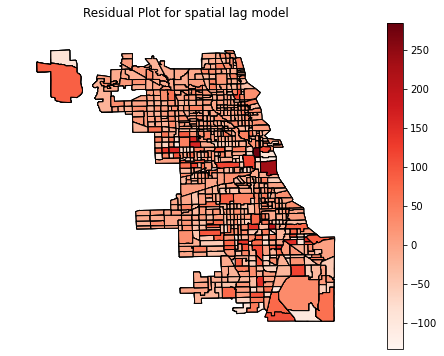

In [74]:
import mapclassify
import geoplot as gplt
import geoplot.crs as gcrs

slag_resids = mapclassify.Quantiles(violent['slag_u'], k=10)

plt.figure(figsize=(10,10))
ax0 = gplt.choropleth(
    chi, hue='slag_u',
    cmap='Reds',legend=True);

plt.title("Residual Plot for spatial lag model")

plt.savefig("spatial.png",bbox_inches = 'tight')

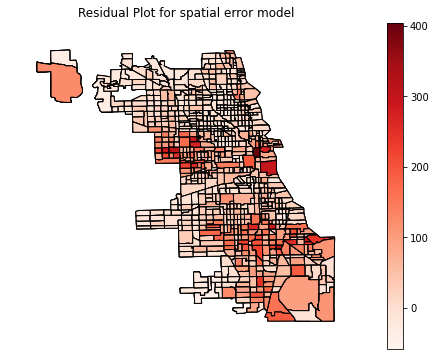

In [75]:
error_resids = mapclassify.Quantiles(chi['error_u'], k=10)

ax0 = gplt.choropleth(
    chi, hue='error_u',
    cmap='Reds',legend=True);

plt.title("Residual Plot for spatial error model")

plt.savefig("error.png",bbox_inches = 'tight')

The above plots show the residuals of the spatial lag model and error model geographically. However, according to the two plots above, we cannot make any significant differences in pattern between the two maps. Therefore, we can consider the other evaluation methods in terms of the two variables.

In [96]:
import esda
print("Moran's I significance levels for Spatial Error Model: " + str(esda.Moran(chi['error_u'], w).p_sim))
print("Moran's I significance levels for Spatial Lag Model: " + str(esda.Moran(chi['slag_u'], w).p_sim))

print("F stat for Spatial Lag Model: " + str(spreg.diagnostics.f_stat(slag)))
print("F stat for Spatial Error Model: " + str(spreg.diagnostics.f_stat(serr)))
print("R squared for Spatial Lag Model: " + str(spreg.diagnostics.r2(slag)))
print("R squared for Spatial Error Model: " + str(spreg.diagnostics.r2(serr)))

Moran's I significance levels for Spatial Error Model: 0.001
Moran's I significance levels for Spatial Lag Model: 0.001
F stat for Spatial Lag Model: (239.72003711773453, 0.0)
F stat for Spatial Error Model: (57.67772834264627, 4.229252933955748e-195)
R squared for Spatial Lag Model: 0.5535823472242103
R squared for Spatial Error Model: -0.2696092605846183


In order to further examine the performance of two models, I calculated three diagnostic
statistics, Moran’s I significance Level, F statistics, and R squared value. According to the Moran’s I significance level, no conclusions can be made. The F statistics shows that the Spatial Lag model has a higher F stat compared to the Spatial Error Model. According to the R-squared value, the R-squared value for the spatial error model is negative, which indicate a poor performance.
Therefore, after a deeper diagnostic procedure, we should adopt the spatial lag model as the best model.

In [83]:
spreg.diagnostics.likratiotest(slag, serr)

{'df': 1, 'likr': 49.766912516024604, 'p-value': 1.7313928137541455e-12}

In [85]:
print(spreg.diagnostics.r2(slag))
print(spreg.diagnostics.r2(serr))

0.5535823472242103
-0.2696092605846183


In [87]:
spreg.diagnostics.breusch_pagan(slag)

{'bp': 656.2606481530219, 'df': 19, 'pvalue': 6.545676237025011e-127}

In [88]:
spreg.diagnostics.breusch_pagan(serr)

{'bp': 956.0165471863809, 'df': 19, 'pvalue': 1.2882732194872888e-190}

### 7. Geographically Weighted RegressionGWS

After finding the best spatial regression model from the above sections, another approach to analyze the data would be via the geographically weighted regression method (GWR).

The Spatial Lag model provides a considerably accurate and reliable model for spatial data analysis and prediction. However, for most of the cases, the relationship might vary spatially. It is reasonable and understandable to assume that the relationships across spaces are significantly different. In order to take this variability into consideration, GWR can be used to create a model that allows the relationships to vary across the space.

In [11]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
import numpy as np

In [12]:
violent.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,violent_co,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2000,POP00_SQMI,POP2009,POP09_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,OTHER,MULT_RACE,HISPANIC,MALES,FEMALES,AGE_UNDER5,AGE_5_17,AGE_18_21,AGE_22_29,AGE_30_39,AGE_40_49,AGE_50_64,AGE_65_UP,MED_AGE,MED_AGE_M,...,eEAT_MDOC,eEAT_F25P,eEAT_F9G,eEAT_F10G,eEAT_F11G,eEAT_F12N,eEAT_FHSC,eEAT_FCG1,eEAT_FCG1P,eEAT_FASD,eEAT_FBAC,eEAT_FMAS,eEAT_FPRO,eEAT_FDOC,eTPOP,eMALES,eFEMALES,eLABFORCE,eLABMALES,eLABFEMALE,eEMPLOYED,eEMPMALES,eEMPFEMALE,eTAGRFRFSH,eTMINING,eTCONSTR,eTMANUFACT,eTWHOLESAL,eTRETAIL,eTTRANSPUT,eTINFORMAT,eTFINACT,eTPROFBUS,eTEDUHLTH,eTLEISHOSP,eTOTHER,eTPUBADMIN,eTTOTALEMP,eMAGRFRFSH,count_violent
0,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19156,17,31,17031,440300,17031440300,5165,10330.0,4888,9836.0,25,5060,8,3,8,10,51,26,2264,2901,281,737,171,442,638,767,880,1249,43.9,41.9,...,6,1695,7,36,27,83,375,151,306,116,263,229,45,12,4138,1812,2326,2064,942,1117,1749,743,1006,120,121,121,121,123,124,124,125,127,127,127,127,130,132,1749,52,273
1,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19157,17,31,17031,440400,17031440400,3833,6182.3,3588,5827.4,23,3777,1,8,0,3,21,16,1741,2092,251,640,174,395,480,524,645,724,39.5,36.9,...,6,1269,29,29,29,128,314,89,267,84,160,84,0,0,3218,1459,1759,1408,664,738,1134,476,658,77,77,79,79,79,80,80,83,83,83,83,83,84,84,1134,32,273
2,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19158,17,31,17031,440500,17031440500,11,84.6,11,84.6,1,9,0,0,0,0,1,0,5,6,1,2,1,0,1,4,1,1,42.2,42.8,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,273
3,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19159,17,31,17031,440600,17031440600,2404,9246.2,2303,8919.2,12,2356,1,4,5,8,18,16,1090,1314,155,424,108,177,330,414,351,445,40.2,38.1,...,0,935,25,5,26,30,172,50,225,33,243,85,16,0,2356,1063,1293,1157,495,660,1042,396,646,72,72,72,72,74,74,75,75,76,76,76,76,76,76,1042,27,273
4,44,44.0,31,17031842400,8424.0,Census Tract 8424,NaN,17,842400,273.0,19182,17,31,17031,490100,17031490100,596,4584.6,555,4292.3,3,581,1,1,0,7,3,12,269,327,42,148,33,39,85,80,85,84,35.0,30.8,...,0,208,12,8,11,9,67,11,57,16,12,0,0,0,517,229,288,201,72,127,110,43,67,7,7,7,8,8,8,8,8,8,8,8,8,8,9,110,3,273


In [13]:
u = chi.geometry.centroid.x
v = chi.geometry.centroid.y
coords = np.array(list(zip(u,v)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


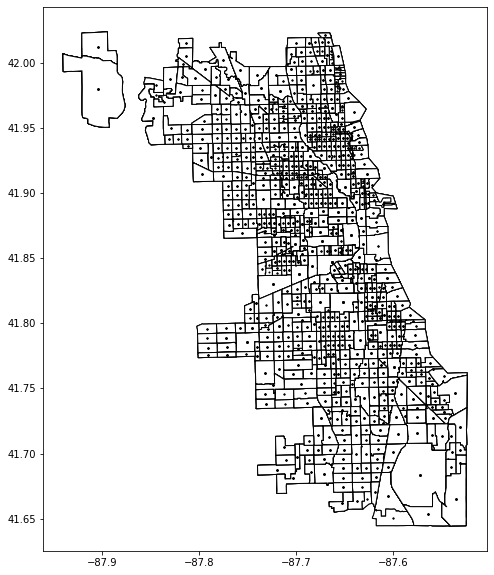

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
chi.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
chi.centroid.plot(ax=ax, c='black', markersize=1)

In [16]:
chi_y = violent['count_violent'].values
chi_y = chi_y.reshape((-1,1)) #-1 infers the shape of the original object, 1 states that we want a 1d array.
chi_X = chi[["POP2009", "MED_AGE","eSHAVGINC",
                    "eSPERCPINC", "eFMMEDINC", "eTotExpend",
                    "eTVhclPrch", "eTCarTrkN", "eReading",
                    "eTobacco",	"eEAT_MCG1", "eEAT_MCG1P",
                    "eEAT_MASD",	"eEAT_MBAC", "eEAT_FCG1",
                    "eEAT_FCG1P", "eEAT_FASD",	"eEAT_FBAC",
                    "eEMPLOYED"]].values

In [17]:
chi_X = (chi_X - chi_X.mean(axis=0)) / chi_X.std(axis=0)
chi_y = (chi_y - chi_y.mean(axis=0)) / chi_y.std(axis=0)

In [18]:
gwr_selector = Sel_BW(coords, chi_y, chi_X,kernel='bisquare')
gwr_bw = gwr_selector.search(criterion="CV")
print(gwr_bw)

376.0


In [19]:
gwr_results = GWR(coords, chi_y, chi_X, gwr_bw).fit()

In [20]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                4276
Number of covariates:                                                    20

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           3226.126
Log-likelihood:                                                   -5465.029
AIC:                                                              10970.059
AICc:                                                             10972.276
BIC:                                                             -32357.326
R2:                                                                   0.246
Adj. R2:                                                              0.242

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Table 6 shows the summary output of the GWR model. As we can see from the test statistics, the GWR model has a R-squared value at 0.562, which is higher than the R-Squared value for the Spatial Lag model, 0.554. That means that the GWR model have a higher explanatory power compared to the Spatial Lag model. The log-likelihood for GWR model is significantly higher than the that for the spatial lag model. In that case, we can conclude that GWR can be a better fit
for the spatial data. However, we cannot make any interpretation on the model based on the output summary. In order to understand the model better, we can visualize the output to a map.

In [33]:
chi['coef_unemployed'] = gwr_results.params.transpose()[19]
chi['coef_pop'] = gwr_results.params.transpose()[1]

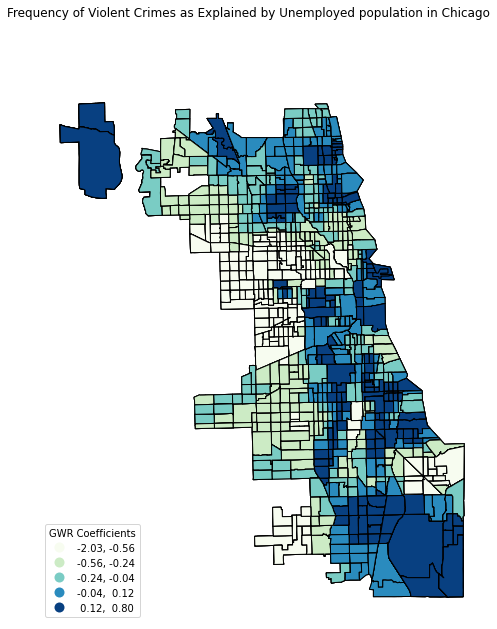

In [32]:
fig, ax = plt.subplots(1, figsize=(15,10))
fig.suptitle('Frequency of Violent Crimes as Explained by Unemployed population in Chicago')
ax.set_axis_off()
chi.plot(ax=ax, column='coef_unemployed', scheme='quantiles', cmap='GnBu', k=5, legend=True,\
           legend_kwds={'title':'GWR Coefficients'}, **{'edgecolor':'black'})
leg = ax.get_legend()
leg._loc = 3



plt.savefig("GWR unemployment.png",bbox_inches = 'tight')
plt.show()

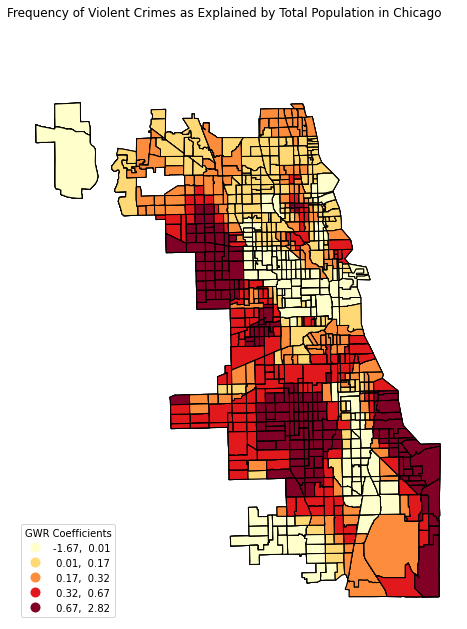

In [35]:
fig, ax = plt.subplots(1, figsize=(15,10))
fig.suptitle('Frequency of Violent Crimes as Explained by Total Population in Chicago')
ax.set_axis_off()
chi.plot(ax=ax, column='coef_pop', scheme='quantiles', cmap='YlOrRd', k=5, legend=True,\
           legend_kwds={'title':'GWR Coefficients'}, **{'edgecolor':'black'})
leg = ax.get_legend()
leg._loc = 3



plt.savefig("population.png",bbox_inches = 'tight')
plt.show()

The graphs above show the difference in relationship between independent variable, Unemployed Population and Total Population, and the dependent variable Violent Crime
frequency. The reason we are examine the performance of these two variables is that those two variables are the ones with the highest statistical significance in the spatial lag model. From the graphs we can see that the relationships differ cross the span of the map.

The graph on the left visualizes the coefficients of violent crimes regressed against unemployment population. The darker areas indicates that there is strong positive relationship between the two variables. For example, Far Southeast Side, South Side and Far North Side all show that there is positive relationship between unemployed population and the number of violent crimes in these specific areas. However, for lighter areas like Southwest Side, and West Side all shows that there is negative relationship between population and the number of violent
crimes.

Similarly, we can apply the same logic to the graph on the right that shows the coefficients of violent crimes against total population. Areas like South Chicago, East Side and Lawndale indicate positive relationship between total population and violent crimes, where areas like
O’hare, Humboldt Park and Near West Side indicate negative relationship between the two variables.

After a series of analysis based on the GWR model, we can see that it is difficult to draw conclusive statements from the model as each plot only represents one variable at a time, ignoring the influence of other variables that might have on the pattern. In other words, the pattern that we see from the plots above might be the result of a combination of influences from other factors that are not included in each graph. Therefore, we can only examine the patterns of the variables visually. In order to draw quantitative conclusions, we still need use the results from the Spatial Lag model we created in the previous section.


### 8. Analysis on the results from Spatial Lag Model

After multiple approaches to evaluate the different spatial regression models built to target the issue of violent crimes, we decided to use spatial lag regression model as the fundamental model. From the results shown in table 4, we can see that population (variable 1), the population of male aged 25+ with some college education under 1-year (variable 2), female population 25+ with 1+ years of college education without a degree (variable 3), and the unemployed population (variable 4) are some of the most statistically significant factors that might influence the number of violent crimes in the city of Chicago.
It shows that variable 1 and variable 3 are positively correlated with the target variable violent crime, while variable 2 and variable 4 are negatively correlated with the target variable. It is understandable that areas with larger population can be a more dangerous, as population density increases, the possibility to encounter violent criminals also increases.

The negative relationship between the population of female with college education over 1 year
and violent crime is somewhat counterintuitive. However, in the specific case of Chicago, it is comparatively understandable. A possible explanation to this finding is the area where The University of Chicago is located. The University of Chicago is located near the Hyde Park area, which is also notoriously known as an area with gangs and violence. From the LISA plot in section 4, we can see that Hyde Park area is a High-Low area, which means it is an area with high crime rate surrounded by low crime rate areas. Although the campus area is often considered to be comparatively safer, the violent crimes near campus in the same area might be a determining factor influencing the regression result.
In that case, variable 2 should show a similar result as variable 3. However, variable 2 is negatively related to the target variable. The difference in coefficients between these two
variables might be an evidence showing that female college students are more vulnerable to violent crimes compare to male college students. This is a somewhat dangerous and alarming conclusion as the officials and university administrators have to pay more attention on ensuring the safety for female college students on campus.

For variable 4, the negative relationship indicates that the lower the unemployment population, the higher the violent crimes. It can be explained by the logic that the lower the unemployment population, the higher the number of potential targets for violent crimes, especially robbery. Although empirically, higher unemployment might also mean a larger number of potential
violent criminals. However, according to the result from the model, the influence of the increase in potential targets out exceeds the influence of the increase in potential criminals.

The spatial lag term W_violence shows that the surroundings of an area might be influential as well. This variable indicates a spatial clustering for violent crimes in Chicago. Hopefully, the results from the model can be a useful source for government officials or police departments to increase the personnel in certain clusters with high violent crimes to ensure the safety of these specific areas indicated from the LISA plot.

To evaluate the model in general, the R-squared value for the Spatial Lag Model is 0.554, which is a comparatively reliable model used for analysis. However, since the dataset used was filtered from a larger census tract data. To include all the variables in the analysis is time consuming. It is understandable that this spatial lag model might not be the best and most accurate model to predict violent crimes in Chicago, but it can provide a certain degree of insights for government policy making and for future research.

### 9. Conclusion

The crime rate in Chicago has been one of the most important social issues in the United States. From a theoretical point of view, study the crimes in Chicago can, ideally, provide some insights on the decision and policy making to mitigate the crime and thus decrease the frequency of crimes in certain areas in Chicago. In this study, we focused on the violent crimes specifically. We examined the distribution of violent crimes, spatial mean, spatial clustering, and build several models to analyze the impact of some demographic factors on the number of violent
crimes in different areas in Chicago.

From the model output, we found that the total population and female population 25+ with 1+ years of college education without a degree are negatively related to the violent crimes in Chicago, while the unemployed population and the population of male aged 25+ with some college education under 1-year are positively related to the target variable. The study also shows that there is a certain degree of spatial clustering for violent crimes in Chicago.

The spatial model built and the model outputs in this study can provide a general understanding
on the distribution of violent crimes in Chicago. Although, substantively, policy makings are not arbitrarily dependent on crime studies in Chicago alone, hopefully, From a theoretical point of view, this study in the violent crimes in Chicago can provide some insights on the decision and policy making to mitigate the crime and thus decrease the frequency of crimes in certain areas in Chicago.